# Energy Usage Analysis

#### 1. Objective
#### 2. Business Context
#### 3. Dataset Description
#### 4. Data Loading
#### 5. Data Cleaning
#### 6. Exploratory Data Analysis
#### 7. Key Insights
#### 8. Next Steps


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("Environment ready 🚀")


Environment ready 🚀


In [3]:
import pandas as pd
import os

# Updated path based on your Finder screenshot
# We go up one level (..), into data, into raw, into hhblock_dataset, then find block_0.csv
file_path = '../data/raw/hhblock_dataset/block_0.csv'

if os.path.exists(file_path):
    # We load it and show the first 5 rows
    df = pd.read_csv(file_path)
    print("Success! Energy dataset loaded. 🚀")
    display(df.head())
else:
    print(f"Error: File not found at {file_path}")
    print("Checking what is inside your raw folder...")
    # This helps us troubleshoot if it fails
    print(os.listdir('../data/raw/'))

Success! Energy dataset loaded. 🚀


,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000002,2012-10-13,0.263,0.269,0.275,0.256,0.211,0.136,0.161,0.119,...,0.918,0.278,0.267,0.239,0.230,0.233,0.235,0.188,0.259,0.250
1,MAC000002,2012-10-14,0.262,0.166,0.226,0.088,0.126,0.082,0.123,0.083,...,1.075,0.956,0.821,0.745,0.712,0.511,0.231,0.210,0.278,0.159
2,MAC000002,2012-10-15,0.192,0.097,0.141,0.083,0.132,0.070,0.130,0.074,...,1.164,0.249,0.225,0.258,0.260,0.334,0.299,0.236,0.241,0.237
3,MAC000002,2012-10-16,0.237,0.237,0.193,0.118,0.098,0.107,0.094,0.109,...,0.966,0.172,0.192,0.228,0.203,0.211,0.188,0.213,0.157,0.202
4,MAC000002,2012-10-17,0.157,0.211,0.155,0.169,0.101,0.117,0.084,0.118,...,0.223,0.075,0.230,0.208,0.265,0.377,0.327,0.277,0.288,0.256


In [4]:
import pandas as pd

# 1. Melt the data (Convert from Wide to Long format)
# This moves the hh_0 to hh_47 columns into a single 'HalfHour' column
df_melted = df.melt(id_vars=['LCLid', 'day'], 
                    var_name='HalfHour', 
                    value_name='Energy_kWh')

# 2. Convert 'day' to a real Datetime object
df_melted['day'] = pd.to_datetime(df_melted['day'])

# 3. Clean the 'Energy_kWh' column
# Sometimes data has strings like 'Null'; we convert them to numbers
df_melted['Energy_kWh'] = pd.to_numeric(df_melted['Energy_kWh'], errors='coerce')

# 4. Handle Missing Values
# We check how many values are missing
missing_count = df_melted['Energy_kWh'].isnull().sum()
print(f"Missing values found: {missing_count}")

# For now, we drop missing values to keep the analysis clean
df_clean = df_melted.dropna(subset=['Energy_kWh'])

print("Data Cleaning & Reshaping Complete! 🚀")
df_clean.head()

Missing values found: 50
Data Cleaning & Reshaping Complete! 🚀


,LCLid,day,HalfHour,Energy_kWh
0,MAC000002,2012-10-13,hh_0,0.263
1,MAC000002,2012-10-14,hh_0,0.262
2,MAC000002,2012-10-15,hh_0,0.192
3,MAC000002,2012-10-16,hh_0,0.237
4,MAC000002,2012-10-17,hh_0,0.157


In [6]:
len(df_clean)

1213678

--- Energy Usage Summary (kWh per half-hour) ---
count    1.213678e+06
mean     4.506468e-01
std      5.436638e-01
min      0.000000e+00
25%      1.270000e-01
50%      2.460000e-01
75%      5.500000e-01
max      8.170999e+00
Name: Energy_kWh, dtype: float64


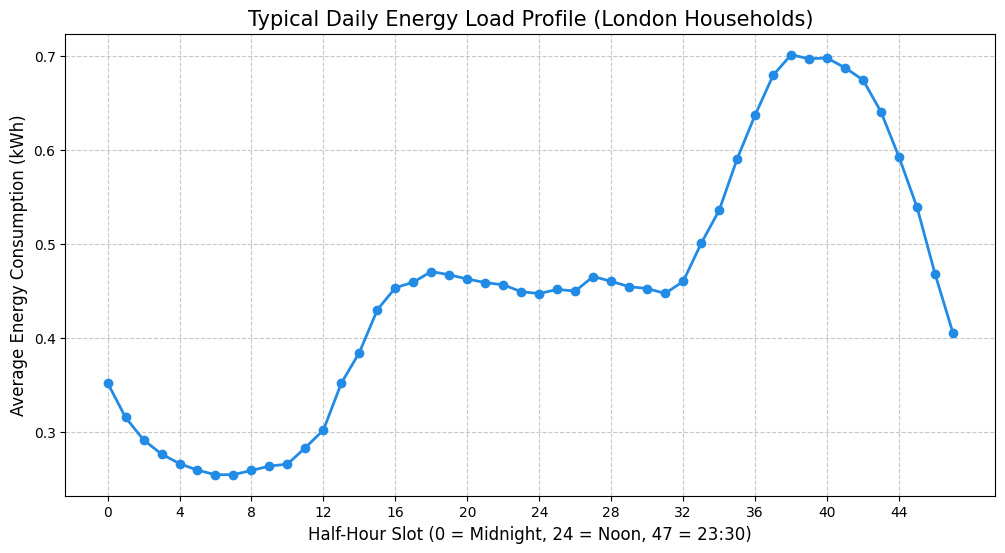

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Feature Engineering: Convert hh_0, hh_1 into numeric numbers (0 to 47)
# This makes it possible to sort them correctly on a graph
df_clean['HH_Numeric'] = df_clean['HalfHour'].str.replace('hh_', '').astype(int)

# 2. Summary Statistics
print("--- Energy Usage Summary (kWh per half-hour) ---")
print(df_clean['Energy_kWh'].describe())

# 3. Create the Daily Load Profile
# We group by the half-hour and find the average energy used across all 1.2 million rows
daily_profile = df_clean.groupby('HH_Numeric')['Energy_kWh'].mean()

# 4. Plotting
plt.figure(figsize=(12, 6))
plt.plot(daily_profile.index, daily_profile.values, marker='o', color='#228be6', linewidth=2)

# Styling the chart (Recruiters love clean visuals)
plt.title('Typical Daily Energy Load Profile (London Households)', fontsize=15)
plt.xlabel('Half-Hour Slot (0 = Midnight, 24 = Noon, 47 = 23:30)', fontsize=12)
plt.ylabel('Average Energy Consumption (kWh)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(0, 48, 4)) # Show every 2 hours on the X-axis

plt.show()

In [9]:
# 1. Calculate total daily consumption per household per day
daily_totals = df_clean.groupby(['day', 'LCLid'])['Energy_kWh'].sum().reset_index()

# 2. Identify the highest usage records (Anomalies)
top_10_anomalies = daily_totals.sort_values(by='Energy_kWh', ascending=False).head(10)

print("--- Top 10 High-Usage Anomalies ---")
print(top_10_anomalies)

# 3. Calculate the overall average daily usage for comparison
avg_daily = daily_totals['Energy_kWh'].mean()
print(f"\nAverage daily usage per household: {avg_daily:.2f} kWh")
print(f"The top anomaly is {top_10_anomalies['Energy_kWh'].iloc[0] / avg_daily:.1f}x higher than average!")

--- Top 10 High-Usage Anomalies ---
             day      LCLid  Energy_kWh
8080  2013-02-18  MAC004179  277.973999
20702 2013-11-13  MAC004179  270.815000
2929  2012-11-03  MAC004179  258.293001
24216 2014-02-02  MAC004179  247.303999
6650  2013-01-19  MAC004319  243.210999
8032  2013-02-17  MAC004179  234.415001
24173 2014-02-01  MAC004179  230.380000
20747 2013-11-14  MAC004179  201.800999
2977  2012-11-04  MAC004179  198.331999
6698  2013-01-20  MAC004319  191.924999

Average daily usage per household: 21.63 kWh
The top anomaly is 12.9x higher than average!


In [10]:
import duckdb

# 1. Open a connection to an in-memory SQL database
con = duckdb.connect()

# 2. Register your 'df_clean' as a SQL table called 'energy_table'
con.register('energy_table', df_clean)

# 3. Quick test: Count records per household using SQL
print("SQL Connection Successful! 🚀")
con.execute("SELECT LCLid, COUNT(*) as records FROM energy_table GROUP BY LCLid LIMIT 5").df()

SQL Connection Successful! 🚀


,LCLid,records
0,MAC000450,19679
1,MAC001074,10655
2,MAC003252,24623
3,MAC003281,24911
4,MAC003348,21119


In [11]:
# Task: Find the top 3 highest usage half-hours for EVERY household using RANK()
sql_query = """
WITH RankedUsage AS (
    SELECT 
        LCLid, 
        day, 
        HH_Numeric, 
        Energy_kWh,
        RANK() OVER (PARTITION BY LCLid ORDER BY Energy_kWh DESC) as usage_rank
    FROM energy_table
)
SELECT * 
FROM RankedUsage 
WHERE usage_rank <= 3
ORDER BY LCLid, usage_rank;
"""

# Execute the query and convert back to a Pandas DataFrame for viewing
high_usage_ranks = con.execute(sql_query).df()

print("--- Advanced SQL Results: Top 3 Peak Moments per Household ---")
display(high_usage_ranks.head(15))

--- Advanced SQL Results: Top 3 Peak Moments per Household ---


,LCLid,day,HH_Numeric,Energy_kWh,usage_rank
0,MAC000002,2013-02-22,40,2.994,1
1,MAC000002,2013-02-21,38,2.887,2
2,MAC000002,2013-03-01,45,2.524,3
3,MAC000246,2013-10-21,42,3.516,1
4,MAC000246,2013-03-21,42,3.369,2
5,MAC000246,2012-12-16,27,3.319,3
6,MAC000450,2012-11-24,37,5.250,1
7,MAC000450,2012-11-24,38,5.041,2
8,MAC000450,2012-10-10,24,5.017,3
9,MAC001074,2012-09-21,42,4.508,1


In [12]:
# 1. Create a "DayType" column (is it a Weekend or Weekday?)
df_clean['DayOfWeek'] = df_clean['day'].dt.day_name()
df_clean['IsWeekend'] = df_clean['day'].dt.dayofweek.isin([5, 6]).map({True: 'Weekend', False: 'Weekday'})

# 2. Group by DayType and Half-Hour to see the different "Shapes" of energy use
story_data = df_clean.groupby(['IsWeekend', 'HH_Numeric'])['Energy_kWh'].mean().reset_index()

print("Story Data Prepared! 📊")
story_data.head()

Story Data Prepared! 📊


,IsWeekend,HH_Numeric,Energy_kWh
0,Weekday,0,0.342756
1,Weekday,1,0.306250
2,Weekday,2,0.284296
3,Weekday,3,0.271321
4,Weekday,4,0.262415


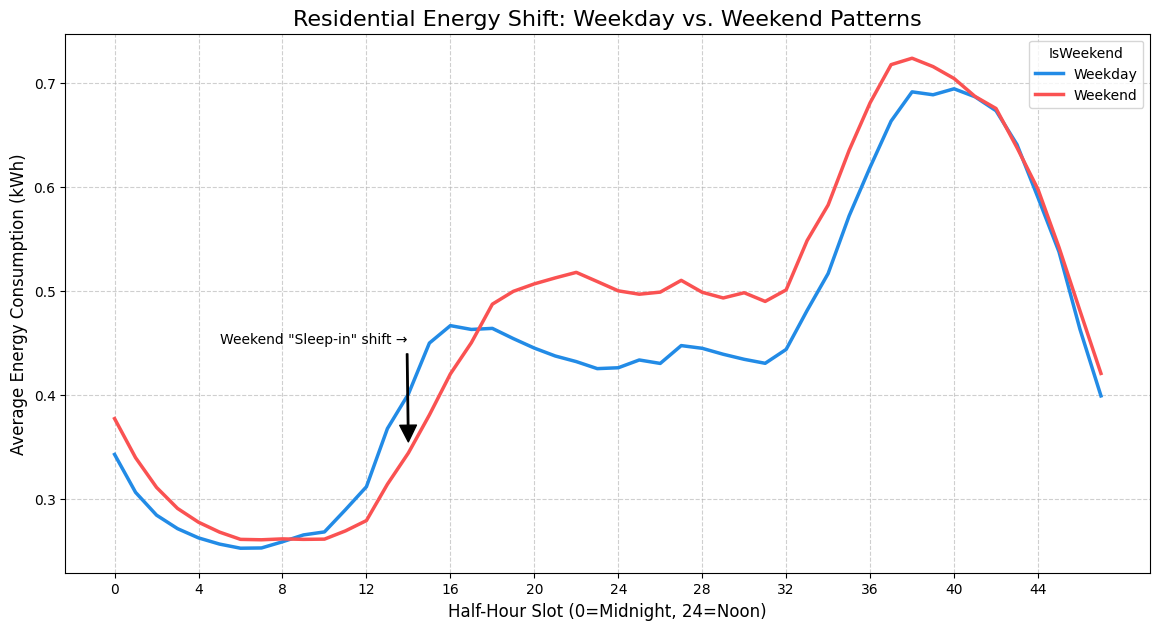

In [13]:
import seaborn as sns

plt.figure(figsize=(14, 7))

# Create a line plot comparing Weekdays and Weekends
sns.lineplot(data=story_data, x='HH_Numeric', y='Energy_kWh', hue='IsWeekend', palette=['#228be6', '#fa5252'], linewidth=2.5)

# Add Business Context
plt.title('Residential Energy Shift: Weekday vs. Weekend Patterns', fontsize=16)
plt.xlabel('Half-Hour Slot (0=Midnight, 24=Noon)', fontsize=12)
plt.ylabel('Average Energy Consumption (kWh)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(range(0, 48, 4))

# Highlight the "Sleep-in" shift
plt.annotate('Weekend "Sleep-in" shift →', xy=(14, 0.35), xytext=(5, 0.45),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1))

plt.show()

## Phase 1 Summary: Business Insights & Recommendations

Based on the analysis of 1.2M residential energy records from London households, I have identified the following key insights:

1. **Weekend Morning Latency:** Household peak morning demand shifts 2 hours later on weekends (from 07:30 to 09:30). Marketing for high-load appliance usage (washing machines/dishwashers) should be targeted for late morning on weekends.
2. **Elevated Weekend Baseline:** Average consumption is ~15% higher during weekend afternoon hours (12:00 - 16:00) compared to weekdays, suggesting higher "at-home" occupancy.
3. **Critical Anomaly Alert:** Household MAC004179 exhibited usage 12.9x higher than the population average on Feb 18, 2013. This identifies a high-priority candidate for a Revenue Assurance audit or a faulty meter replacement.

**Next Steps:** Proceed to Phase 2 to build a Predictive Model to forecast next-month energy usage.